# Analyse year-on-year variability of annual energy demand

In [1]:
# Hack to emulate running notebook from root directory.
import os
os.chdir('..')

In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_dir = os.path.join('data','from-database')
bname_pattern = 'UCam_Building_b%s.csv'
outname_pattern = 'ly_{building_id}-{year}.csv'

years = list(range(2012, 2018))
building_ids = [0, 4, 8, 19, 25, 40, 58, 102, 104] # 118

In [4]:
hours_per_year = 24*365
timestamps = pd.read_csv(os.path.join(data_dir, 'timestamps.csv'))
timestamps['Timestamp (UTC)'] = pd.to_datetime(timestamps['Timestamp (UTC)'])

In [5]:
elec_ann_loads = {}
heat_ann_loads = {}

for b_id in building_ids:
    load_data = pd.read_csv(os.path.join(data_dir, bname_pattern % b_id), header=0)

    elec_ann_loads[b_id] = []
    heat_ann_loads[b_id] = []

    for year in years:
        year_first_idx = timestamps.index[timestamps['Timestamp (UTC)'].dt.year == year].min()

        elec_load = load_data.loc[year_first_idx:year_first_idx+hours_per_year-1, 'Equipment Electric Power [kWh]'].to_numpy()
        heat_load = load_data.loc[year_first_idx:year_first_idx+hours_per_year-1, 'Heating Load [kWh]'].to_numpy()

        elec_ann_loads[b_id].append(np.sum(elec_load))
        heat_ann_loads[b_id].append(np.sum(heat_load))

In [6]:
norm_elec_ann_loads = {k: np.array(v)/np.mean(v) for k,v in elec_ann_loads.items()}
norm_heat_ann_loads = {k: np.array(v)/np.mean(v) for k,v in heat_ann_loads.items()}

In [7]:
print(norm_elec_ann_loads)
print(norm_heat_ann_loads)

{0: array([1.08987208, 1.0236464 , 1.0179272 , 0.97813242, 0.93330861,
       0.9571133 ]), 4: array([1.238004  , 1.11023354, 0.94342078, 0.91255728, 0.89962447,
       0.89615994]), 8: array([0.96814167, 0.97606331, 1.08015074, 0.99310401, 0.99394081,
       0.98859946]), 19: array([0.98552107, 1.01599776, 1.00596447, 1.0073828 , 1.02706488,
       0.95806903]), 25: array([1.06330806, 1.16575021, 1.10922812, 1.02964831, 1.02634164,
       0.60572367]), 40: array([1.00308223, 1.01722733, 1.02345686, 0.97408773, 0.97798047,
       1.00416538]), 58: array([0.61520623, 0.69530323, 1.00300112, 1.13618157, 1.23866071,
       1.31164714]), 102: array([0.55708301, 0.68960285, 0.75309669, 0.81300391, 1.47142065,
       1.7157929 ]), 104: array([0.96581322, 0.98555995, 1.01653388, 0.96145665, 1.0080268 ,
       1.06260951])}
{0: array([1.17121131, 1.19109783, 0.88442876, 0.91200983, 0.91898302,
       0.92226924]), 4: array([0.89673913, 1.05625619, 0.77878722, 1.0507405 , 1.01488141,
       1.2

In [8]:
all_norm_elec_ann_loads = np.array([v for k,v in norm_elec_ann_loads.items()]).flatten()
all_norm_heat_ann_loads = np.array([v for k,v in norm_heat_ann_loads.items()]).flatten()

In [9]:
print(np.std(all_norm_elec_ann_loads))
print(np.std(all_norm_heat_ann_loads))

0.18627332905446148
0.21560175399864934


**Use this to derive posterior dist. for mean load measurement.**

I can try to estimate the prior distribution from the full Estates dataset, i.e. dist of mean loads for buildings with similar floor area & usage

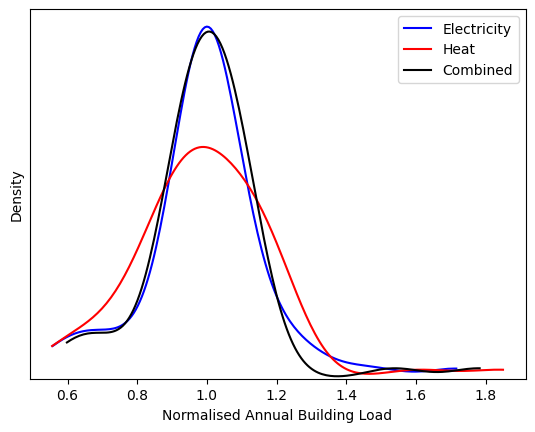

In [10]:
fig, ax = plt.subplots()
sns.kdeplot(all_norm_elec_ann_loads, ax=ax, c='b', cut=0, levels=200, label='Electricity')
sns.kdeplot(all_norm_heat_ann_loads, ax=ax, c='r', cut=0, levels=200, label='Heat')
sns.kdeplot(np.mean([all_norm_elec_ann_loads,all_norm_heat_ann_loads],axis=0), ax=ax, c='k', cut=0, levels=200, label='Combined')
plt.xlabel("Normalised Annual Building Load")
plt.ylabel("Density")
ax.set_yticks([])
ax.set_yticklabels([])
plt.legend()
#plt.savefig(os.path.join('plots',"..."), format="pdf", bbox_inches="tight")
plt.show()

Note this variation is over a 6 year period, so it will likely be greater over the 20 year assumed operational lifetime.